# Items Prediction Process

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import time
from training_functions import *
import logging

In [6]:
logging.basicConfig(level=logging.INFO)

### Functions

#### Get the data from ES and create a pandas dataframe

In [61]:
q_one = es_to_df("2020-06-09","2020-06-13", 20, "censhare", 'localhost', 9200)
q_two = es_to_df("2020-06-09","2020-06-13", 20, "pic", 'localhost', 9200)

INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.128s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.109s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.179s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.170s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.464s]
INFO:root:ES to Df: 1.65 time elapsed
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.151s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:1.326s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:1.151s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.195s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.372s]
INFO:root:ES to Df: 4.73 time elapsed


In [65]:
q_one_size = q_one['size']
q_two_size = q_two['size']

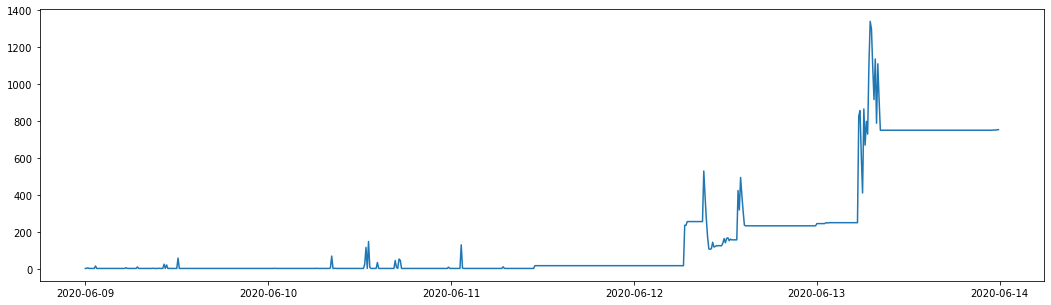

In [66]:
plt.figure(figsize=[18,5])
plt.plot(q_one_size)

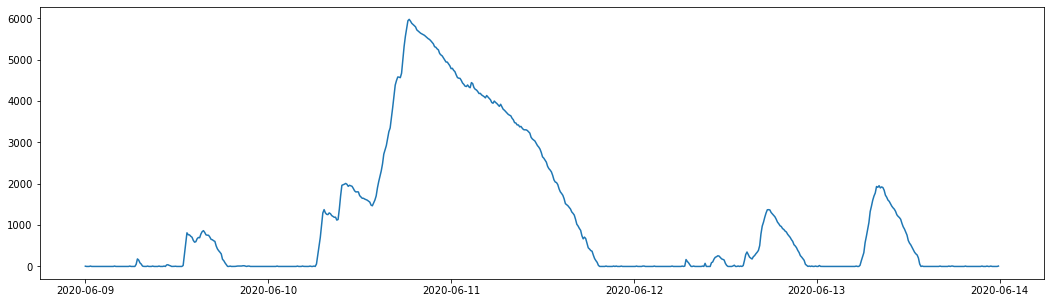

In [67]:
plt.figure(figsize=[18,5])
plt.plot(q_two_size)

#### Create the feature enriched dataset for each item

In [68]:
len(q_one)

720

In [69]:
len(q_two)

720

In [71]:
X, y, maxlen = create_dataset_train(q_one, q_two, 25, 300)

INFO:root:1955 items in the first and second queue
INFO:root:6884 items in the second queue only
INFO:root:8839 items in the whole dataset
INFO:root:Create dataset: 39.08 time elapsed


#### Overview of the samples

Create maxlenlist containing the maximum number of steps each sample is in the queue

In [72]:
maxlenlist = get_max_len_list(y)

Show histogram of the distribution of each sample length

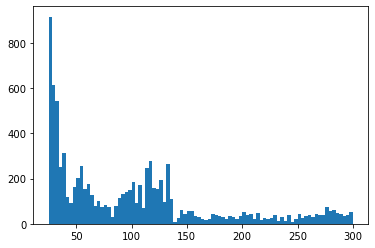

In [73]:
plt.hist(maxlenlist,bins=int(len(maxlenlist)/100))
plt.show()

Show the mean and median of the sample lengths

In [74]:
int(np.mean(maxlenlist))

100

In [75]:
np.mean(maxlenlist), np.median(maxlenlist)

(100.40920918655956, 86.0)

Show the most common occurence of lengths

In [76]:
from collections import Counter

In [77]:
#Counter(maxlenlist).most_common()

Head of an individual sample

In [78]:
X[0].head()

,1000662362,Q_size_one,Q_size_two,n_added_two,n_removed_two,Q_start
0,1,827,0,0,0,0
1,2,856,27,27,1,0
2,3,609,135,135,27,0
3,4,410,233,194,96,0
4,5,865,332,147,48,0


In [79]:
y[0].head()

,1000662362
0,29
1,28
2,27
3,26
4,25


#### Scaling

In [81]:
X_scaled, y_scaled = scale(X, y, "2020-06-09","2020-06-13", '50', '720', '20', 'test')

INFO:root:Scale: 83.35 time elapsed


#### Padding

In [82]:
X_train, X_test, y_train, y_test = pad_split(X_scaled, y_scaled, maxlen, test_size=0.3)

INFO:root:Pad Split: 0.38 time elapsed


In [83]:
X_train[0]

array([[-1.1736996 , -0.27621102,  0.98363584, -0.40753275,  0.5943926 ,
         0.40043932],
       [-1.1584944 , -0.27621102,  0.98312366, -0.30193123, -0.79440176,
         0.40043932],
       [-1.1432892 , -0.23889218,  0.96058697, -0.53660125,  0.06890284,
         0.40043932],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [84]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = downsample(X_train, X_test, y_train, y_test, 0.8)

INFO:root:Downsample: 0.07 time elapsed


In [85]:
X_train_sampled.shape

(4931, 720, 6)

In [86]:
X_train_sampled.shape[1]

720

In [87]:
X_test_sampled.shape

(2103, 720, 6)

MAE        :  39.08403
MAE Mean   :  77.99649
MAE Median :  80.77618


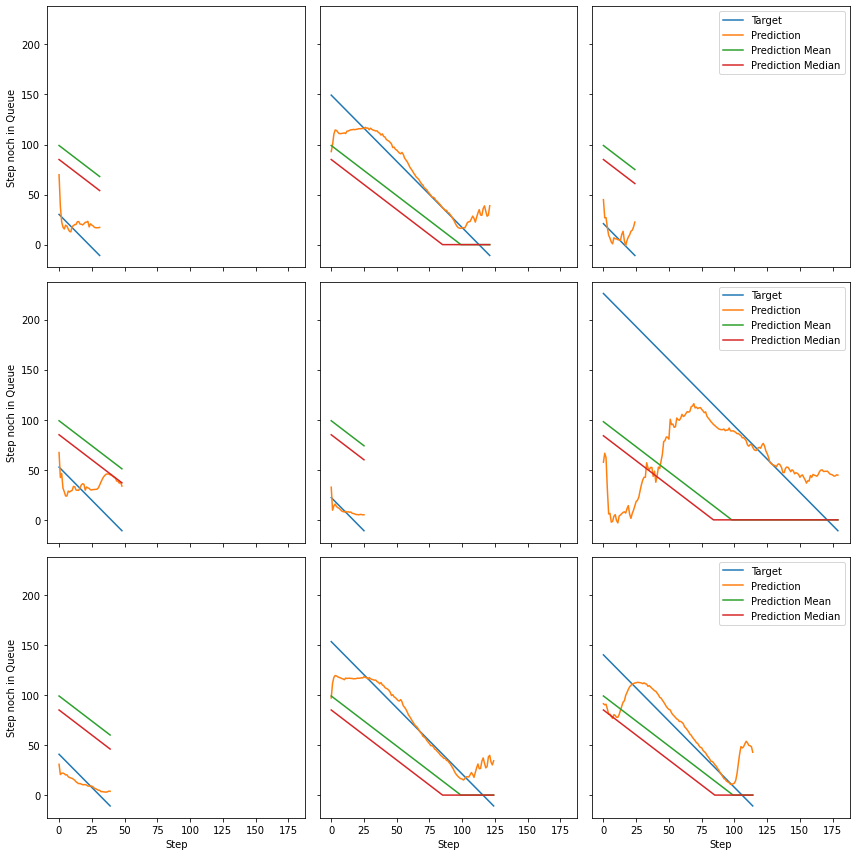

In [92]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5', 'models/scalery_standard_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', 3, 2)

## Model comparison

#### Testing sample weight and masking

Standard Model 20 epochs, no sample weighting, no outliers, masking on

MAE        :  40.10233
MAE Mean   :  84.930626
MAE Median :  86.89382


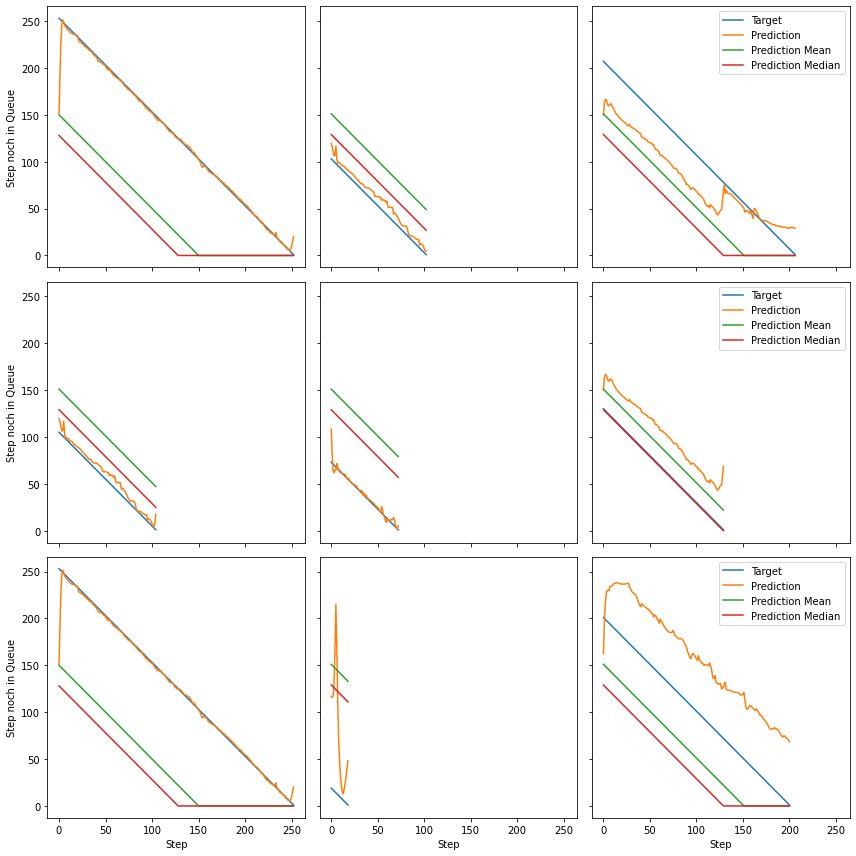

In [22]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard20_epochs.h5', 'models/scaler_y_standard_2q.p', 3, 1)

Masking Model 20 epochs, no sample weighting, masking layer off

MAE        :  41.605335
MAE Mean   :  84.930626
MAE Median :  86.89382


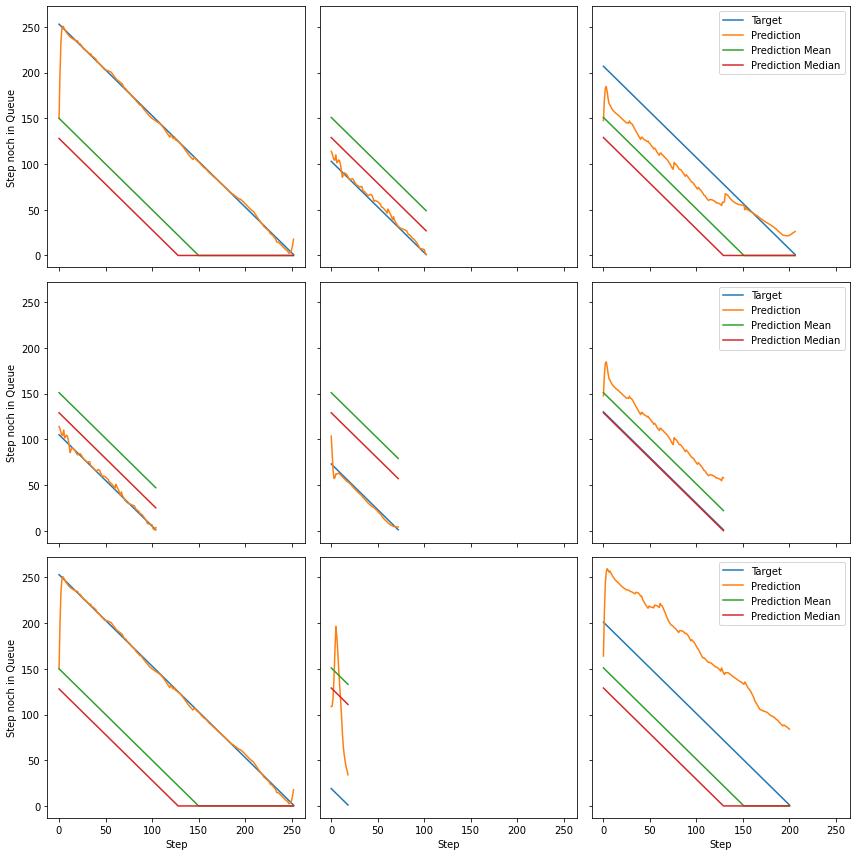

In [24]:
pred_mae(X_test_sampled, y_test_sampled, 'models/masking20_epochs.h5', 'models/scaler_y_standard_2q.p', 3, 1)

Sample Weight Model 20 epochs, sample weighting, masking layer on

MAE        :  46.589108
MAE Mean   :  84.930626
MAE Median :  86.89382


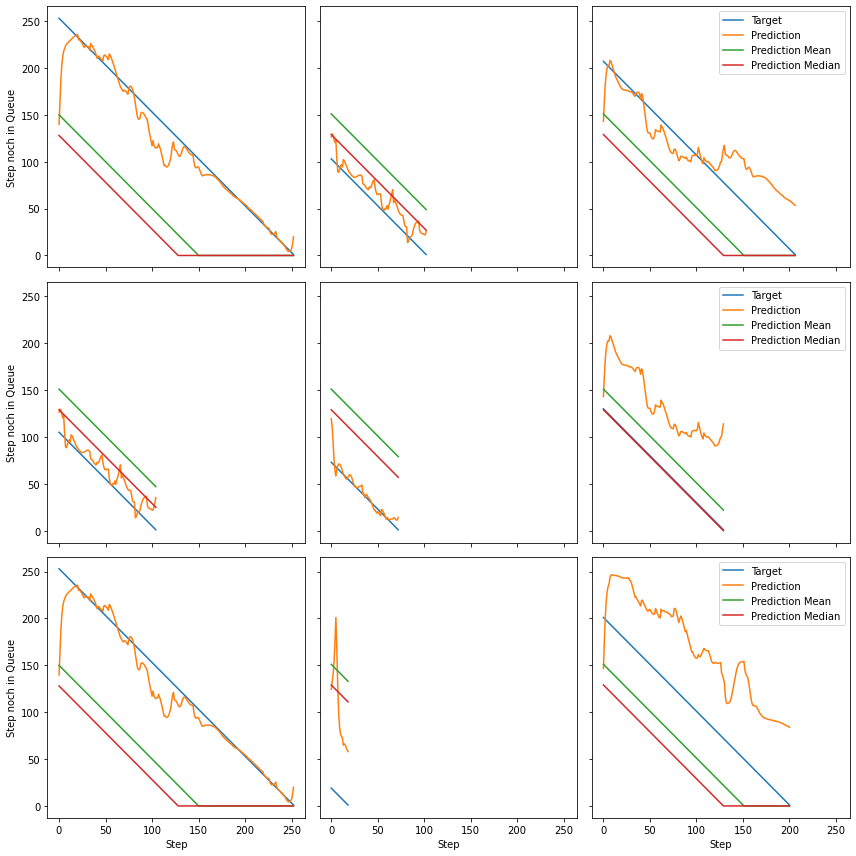

In [25]:
pred_mae(X_test_sampled, y_test_sampled, 'models/sample_weight20_epochs.h5', 'models/scaler_y_standard_2q.p', 3, 1)

Sample Weight + Masking, sample weighting, masking layer off

MAE        :  44.193687
MAE Mean   :  84.930626
MAE Median :  86.89382


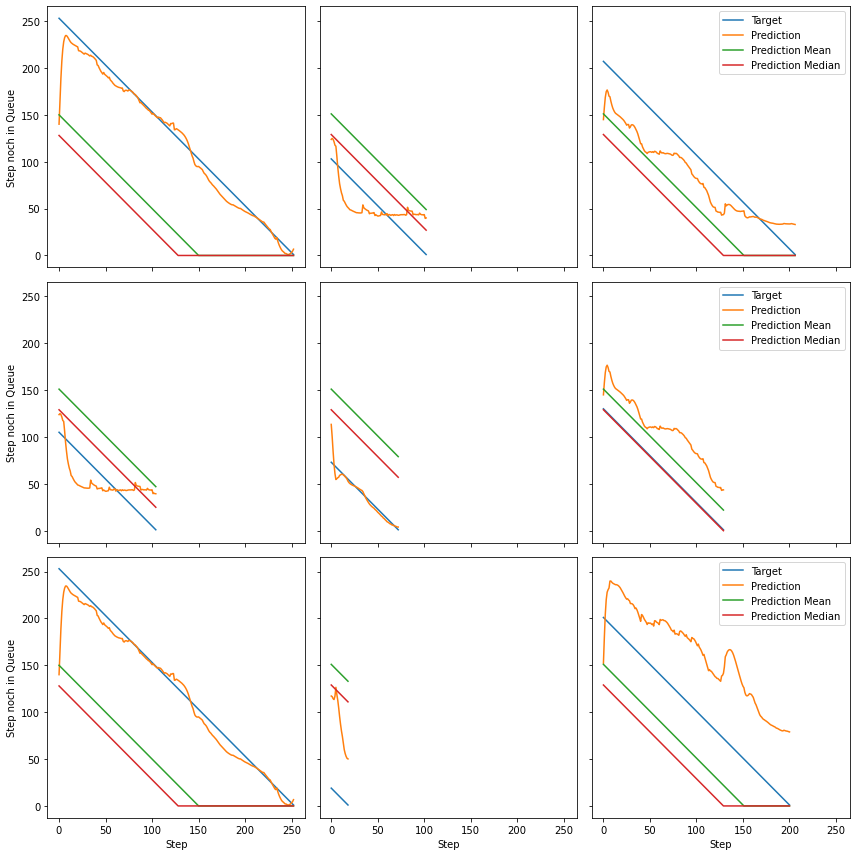

In [26]:
pred_mae(X_test_sampled, y_test_sampled, 'models/masking_sample_weight20_epochs.h5', 'models/scaler_y_standard_2q.p', 3, 1)

#### Testing Neurons

Sample Weighting off and masking layer on, 20 epochs

10 Neurons

MAE        :  44.111748
MAE Mean   :  84.930626
MAE Median :  86.89382


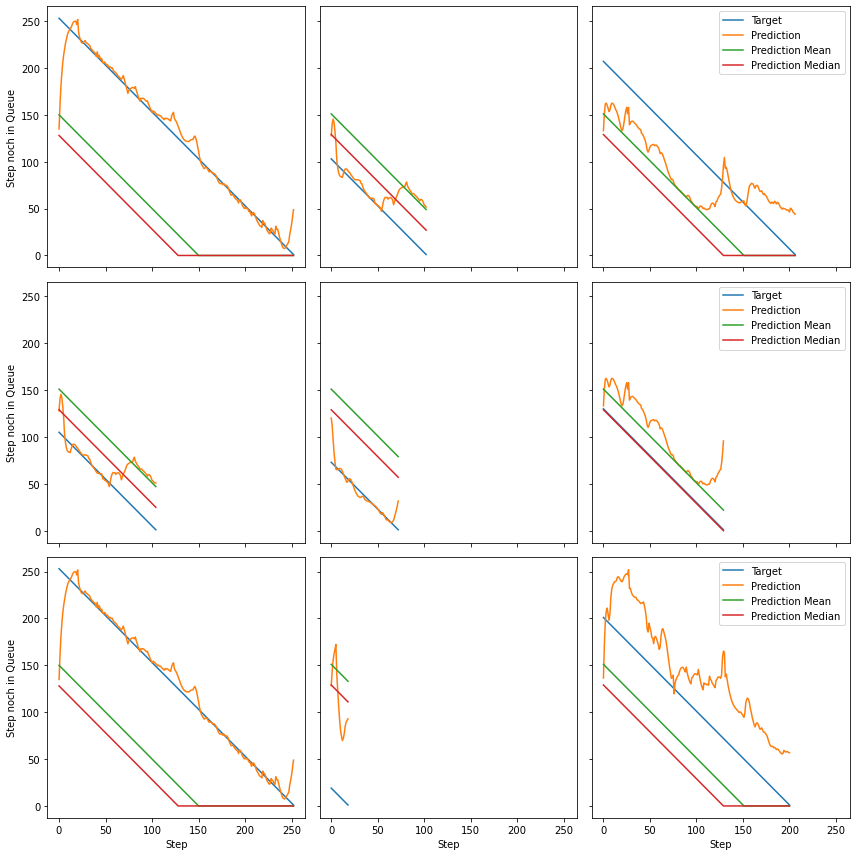

In [41]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_10neurons_20_epochs.h5', 
         'models/scaler_y_standard_10neurons_2q.p', 3, 1)

25 Neurons

MAE        :  44.885826
MAE Mean   :  84.930626
MAE Median :  86.89382


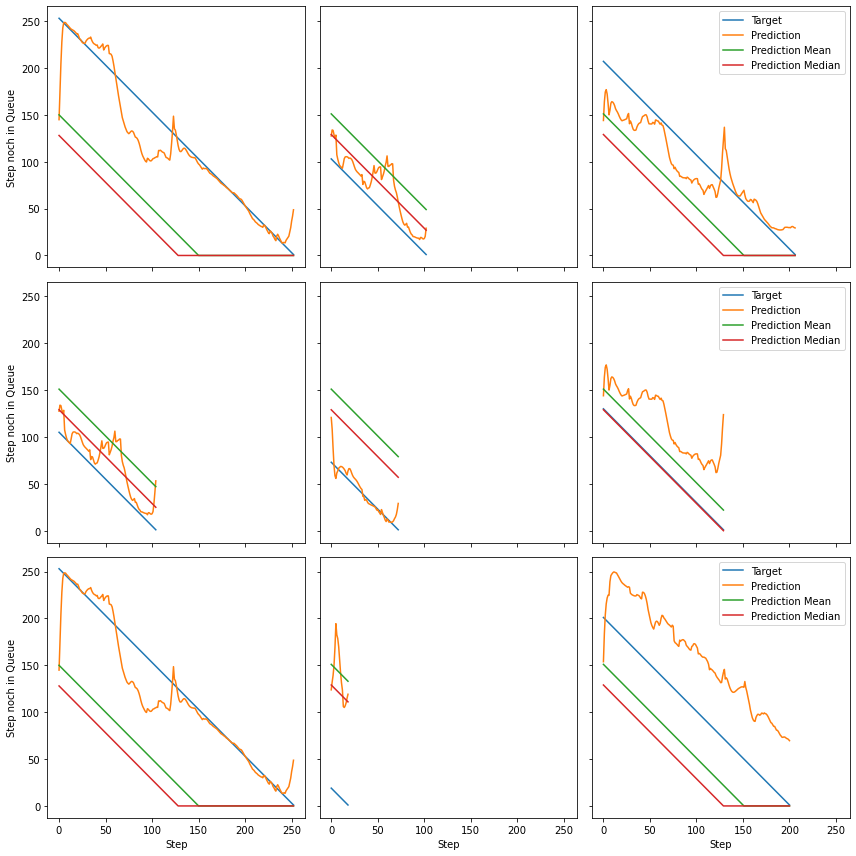

In [40]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_25neurons_20_epochs.h5', 
         'models/scaler_y_standard_25neurons_2q.p', 3, 1)

50 Neurons

MAE        :  40.671967
MAE Mean   :  84.930626
MAE Median :  86.89382


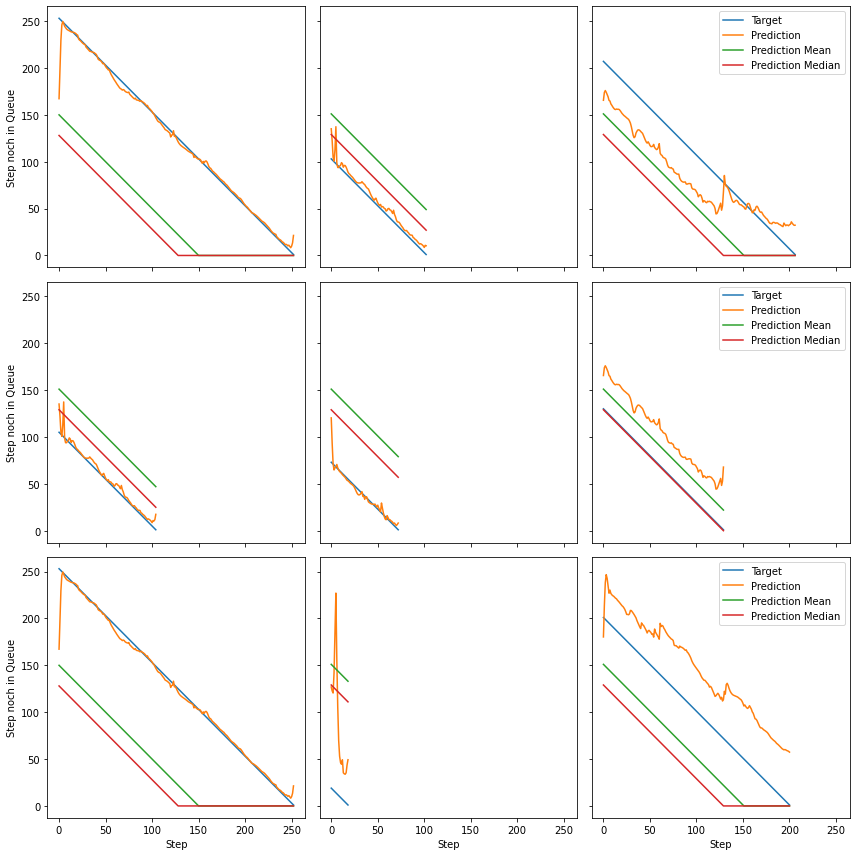

In [39]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_50neurons_20_epochs.h5', 
         'models/scaler_y_standard_50neurons_2q.p', 3, 1)

### Outlier Test

20 Epochs no sample weighting, masking layer on

Outlier threshold min 10, max 400

MAE        :  52.29538
MAE Mean   :  75.72798
MAE Median :  77.50204


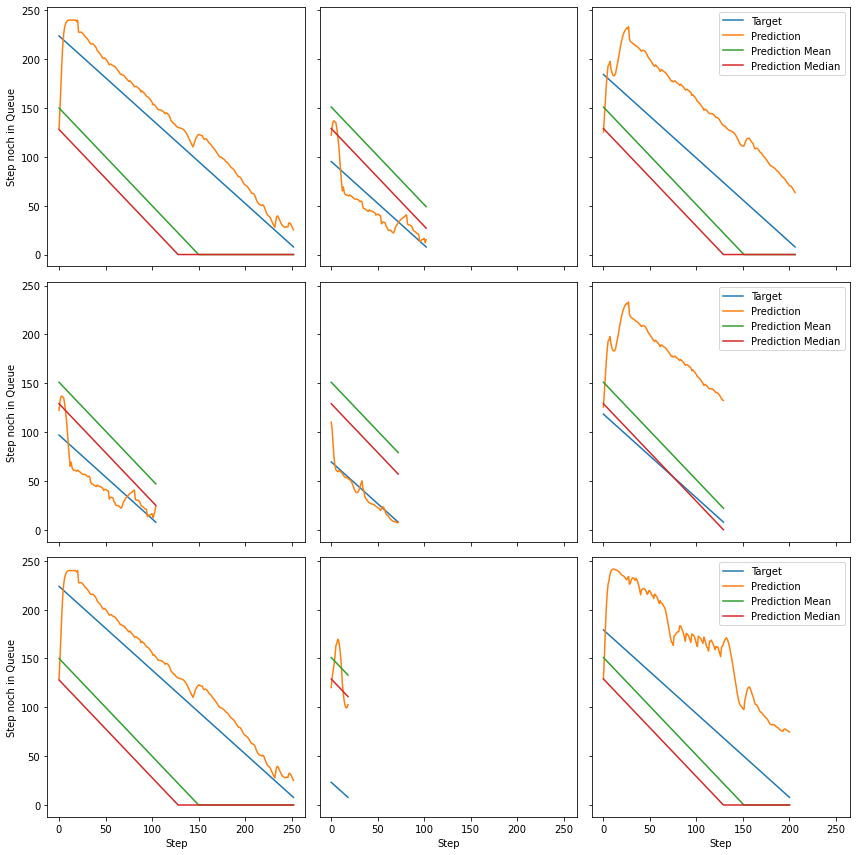

In [37]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_outlier_10_400_20_epochs.h5', 
         'models/scaler_y_standard_outlier_10_400_2q.p', 3, 1)

Outlier threshold min 25, max 400

MAE        :  42.84251
MAE Mean   :  75.91063
MAE Median :  77.80403


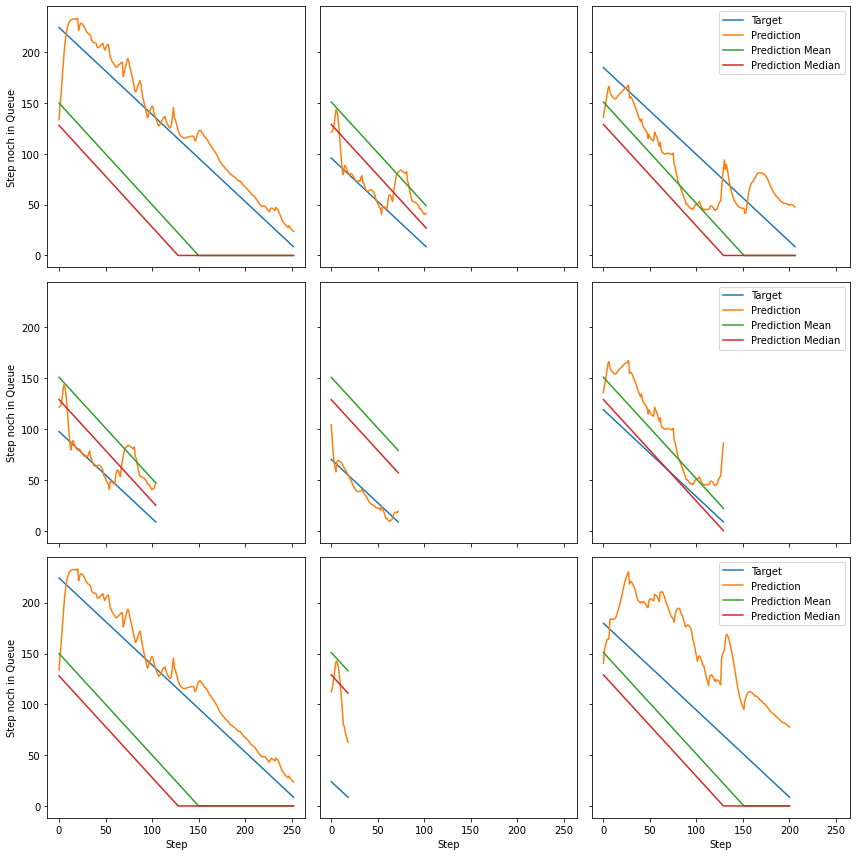

In [36]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_outlier_25_400_20_epochs.h5', 
         'models/scaler_y_standard_outlier_25_400_2q.p', 3, 1)

Outlier threshold min 10, max 300

MAE        :  45.99952
MAE Mean   :  64.98044
MAE Median :  65.94458


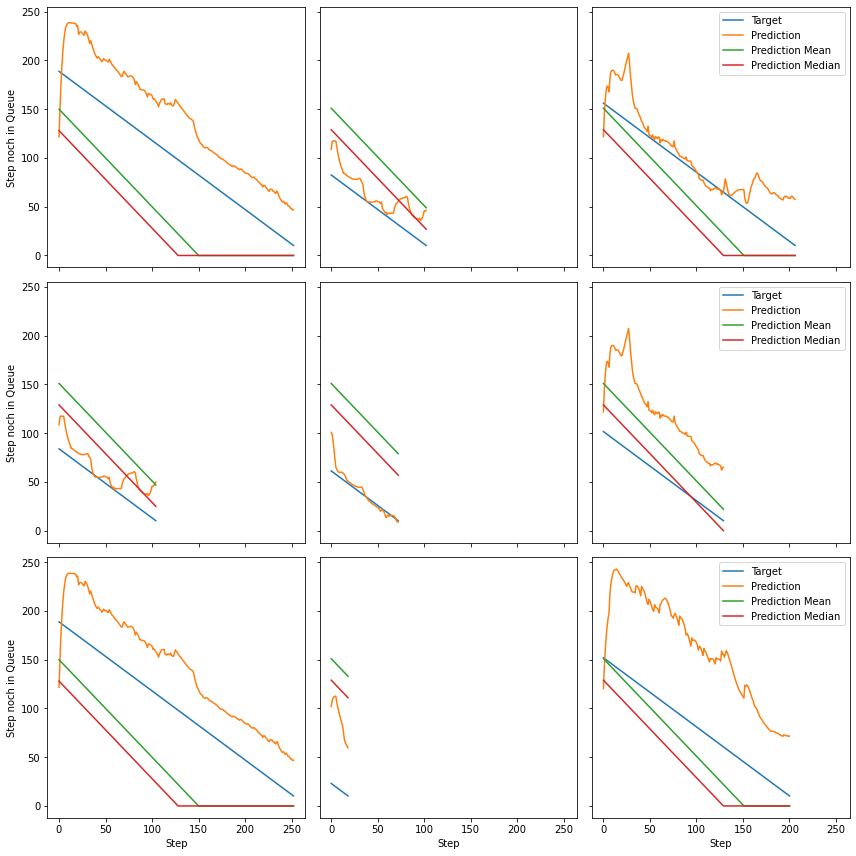

In [35]:
pred_mae(X_test_sampled, y_test_sampled, 'models/outlier_10_300_20_epochs.h5', 
         'models/scaler_y_outlier_10_300_2q.p', 3, 1)

Outlier threshold min 25, max 300

MAE        :  42.465996
MAE Mean   :  65.13195
MAE Median :  66.20131


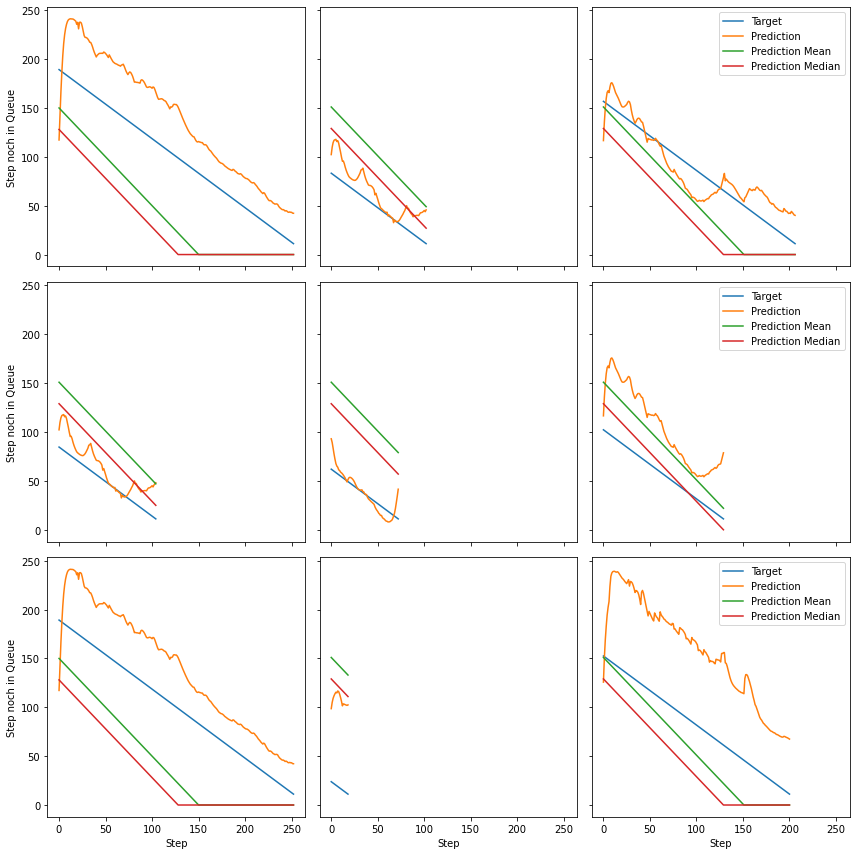

In [34]:
pred_mae(X_test_sampled, y_test_sampled, 'models/outlier_25_300_20_epochs.h5', 
         'models/scaler_y_outlier_25_300_2q.p', 3, 1)

### Epochs Test

10 Epochs

MAE        :  41.359528
MAE Mean   :  75.91063
MAE Median :  77.80403


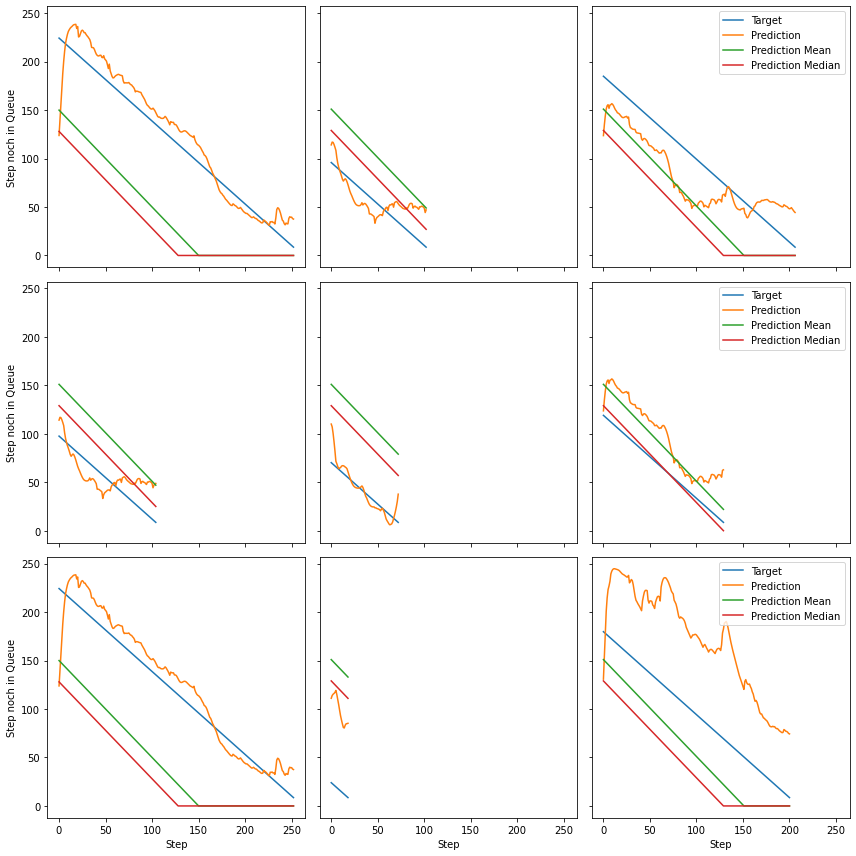

In [43]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_10_epochs.h5', 'models/scaler_y_standard_2q.p', 3, 1)

25 epochs

MAE        :  43.846466
MAE Mean   :  75.91063
MAE Median :  77.80403


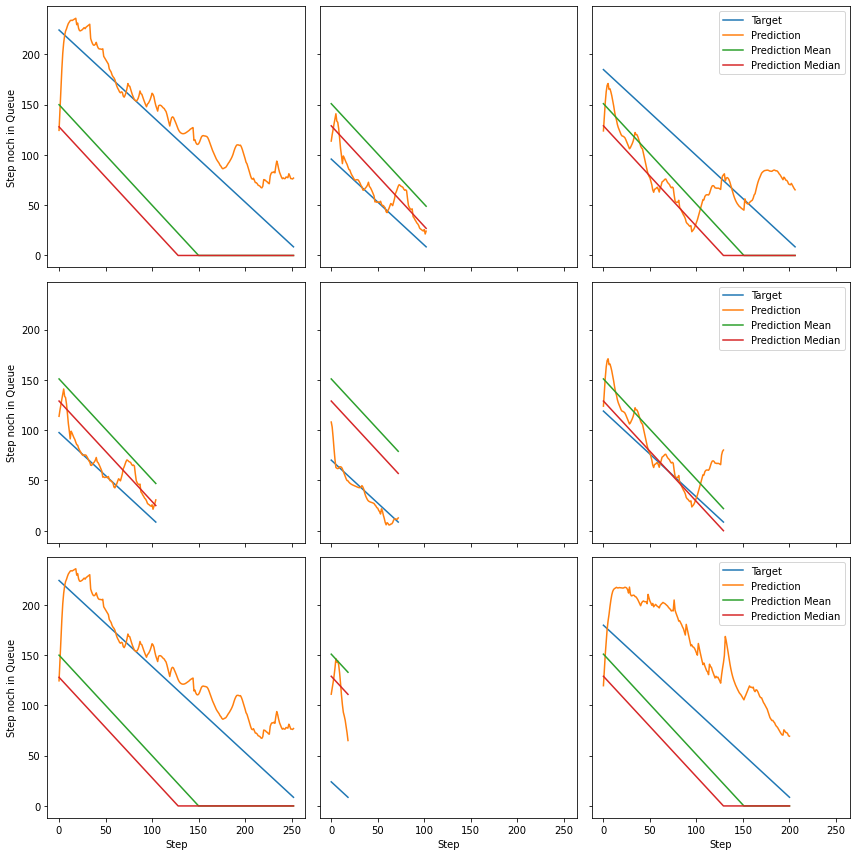

In [44]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_25_epochs.h5', 'models/scaler_y_standard_2q.p', 3, 1)

50 epochs

MAE        :  39.51478
MAE Mean   :  75.91063
MAE Median :  77.80403


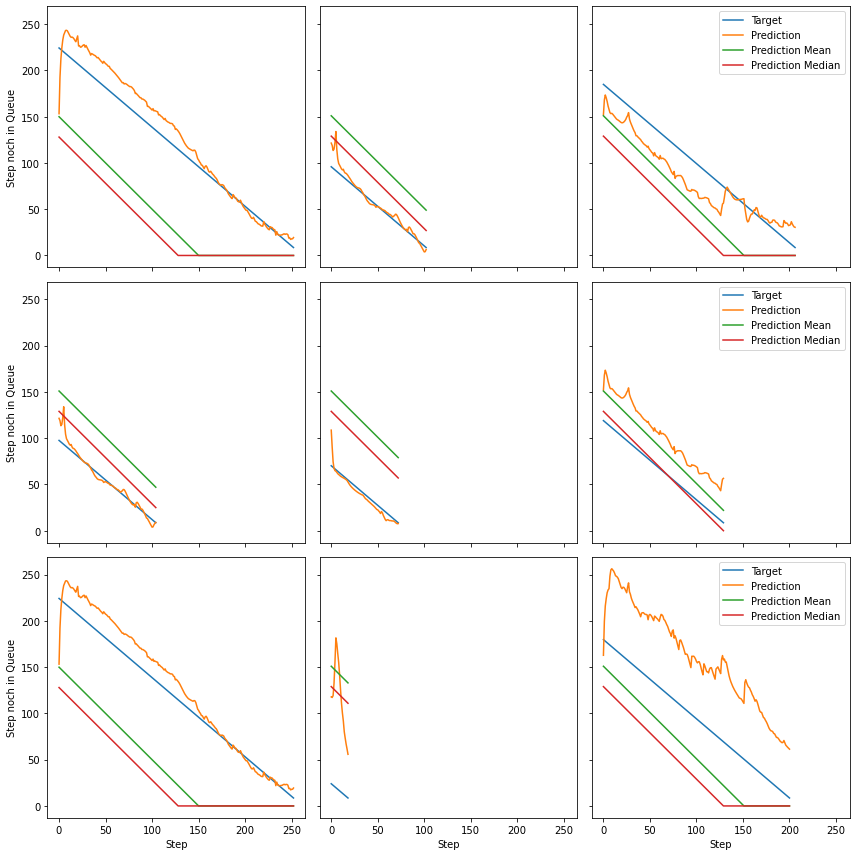

In [45]:
pred_mae(X_test_sampled, y_test_sampled, 'models/standard_50_epochs.h5', 'models/scaler_y_standard_2q.p', 3, 1)

## Appendix

In [24]:
%load_ext line_profiler

In [11]:
%lprun -f create_dataset_train create_dataset_train(q_one, q_two)

Items in both qs:  2769
14067 items in the dataset
11298 items in the second q
